In [9]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [10]:
import torch
import os
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.multiprocessing as mp
import gzip
from torch.utils.data import random_split
from torchsummary import summary

In [11]:
class CustomDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_list = os.listdir(folder_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        file_path = os.path.join(self.folder_path, file_name)
        with gzip.open(file_path, 'rb') as f:
            loaded_data = torch.load(f, map_location=torch.device('cpu'))

        data = loaded_data[0]
        label = loaded_data[1]

        # Perform any necessary preprocessing on the data and label
        # ...

        return data, label

In [12]:
class HPermDataset(Dataset):
    def __init__(self, folder_path, translation_range=10):
        self.folder_path = folder_path
        self.file_list = os.listdir(folder_path)
        self.translation_range = translation_range  # Maximum horizontal translation range

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        file_path = os.path.join(self.folder_path, file_name)
        with gzip.open(file_path, 'rb') as f:
            loaded_data = torch.load(f, map_location=torch.device('cpu'))

        data = loaded_data[0]
        label = loaded_data[1]

        # Apply horizontal translation
        translation_amount = np.random.uniform(-self.translation_range, self.translation_range)
        translated_data = torch.roll(data, int(translation_amount), dims=2)

        return translated_data, label


In [13]:
folder_path= "/content/gdrive/MyDrive/Voxel_Grid_classifier/Data/Transformed_Data/Transform_1/Test_Set"
test_dataset=HPermDataset(folder_path)

In [14]:
import torch.nn as nn

class SimplerCNN3D(nn.Module):
    def __init__(self, num_classes):
        super(SimplerCNN3D, self).__init__()

        self.conv1 = nn.Conv3d(1, 32, kernel_size=5, stride=2, padding=2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv3d(32, 64, kernel_size=5, stride=2, padding=2)
        self.global_pool = nn.AdaptiveMaxPool3d((1, 1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Specify the input shape
input_shape = (1, 60, 60, 60)

In [ ]:
# Load your trained model
model_path = "/content/gdrive/MyDrive/Voxel_Grid_classifier/Model_2/model2_split.pth"
model = torch.load(model_path, map_location=torch.device('cpu'))

# Set the model to evaluation mode
model.eval()

SimplerCNN3D(
  (conv1): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(2, 2, 2), padding=(2, 2, 2))
  (relu): ReLU()
  (conv2): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(2, 2, 2), padding=(2, 2, 2))
  (global_pool): AdaptiveMaxPool3d(output_size=(1, 1, 1))
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
# Define the device to be used for testing (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the specified device
model = model.to(device)

In [ ]:
# Create a DataLoader to efficiently load the test dataset
batch_size = 32  # Adjust this based on your requirements
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Define a criterion if you need to calculate a loss during testing
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix

# Set the random seed for reproducibility
np.random.seed(0)

# Set the model to evaluation mode
model.eval()

total_loss = 0.0
total_correct = 0
total_samples = 0
num_classes=10

print_interval = 10  # Adjust this value as per your preference

# Create an empty confusion matrix
confusion = np.zeros((num_classes, num_classes), dtype=int)

# Disable gradient computation during testing
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(test_loader):
        # Move the data and labels to the device
        data = data.to(device)
        label = label.to(device)

        # Convert the data and model's weight tensor to Double
        data = data.unsqueeze(1)
        data = data.double()
        model.double()

        # Forward pass
        outputs = model(data)

        # Compute the loss
        loss = criterion(outputs, label)

        # Accumulate loss
        total_loss += loss.item()

        # Calculate the predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Update the confusion matrix
        confusion_batch = confusion_matrix(label.cpu().numpy(), predicted.cpu().numpy(), labels=np.arange(num_classes))
        confusion += confusion_batch

        # Count the number of correct predictions
        total_correct += (predicted == label).sum().item()

        # Update the total number of samples
        total_samples += label.size(0)

        # Print intermediate results
        if (batch_idx + 1) % print_interval == 0:
            average_loss = total_loss / (batch_idx + 1)
            accuracy = total_correct / total_samples
            print(f'Batch [{batch_idx+1}/{len(test_loader)}] - Average Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

average_loss = total_loss / len(test_loader)
accuracy = total_correct / total_samples

print(f'Final Results - Average Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
print('Confusion Matrix:')
print(confusion)


Batch [10/28] - Average Loss: 5.3407, Accuracy: 39.69%
Batch [20/28] - Average Loss: 5.6708, Accuracy: 40.00%
Final Results - Average Loss: 5.7396, Accuracy: 41.64%
Confusion Matrix:
[[10 13  1  1  1  6  0  2  9  3]
 [ 1 44 15  2  0 12  0  2 10  2]
 [ 0  6 59  0  0  9  2  2 11  3]
 [ 3 17 12 15  2 15  7  0 14  2]
 [ 2  5  8  2 13 32 11  1  7  2]
 [ 2  5 10  2  1 65  3  3 10  0]
 [ 2 13 11  7  4 11 18 12  9  4]
 [ 5 19  8  2  1 11  1 29 10  4]
 [ 0 14 10  5  1 14  2  2 48  6]
 [ 1  6  7  1  0  6  2  0  4 60]]


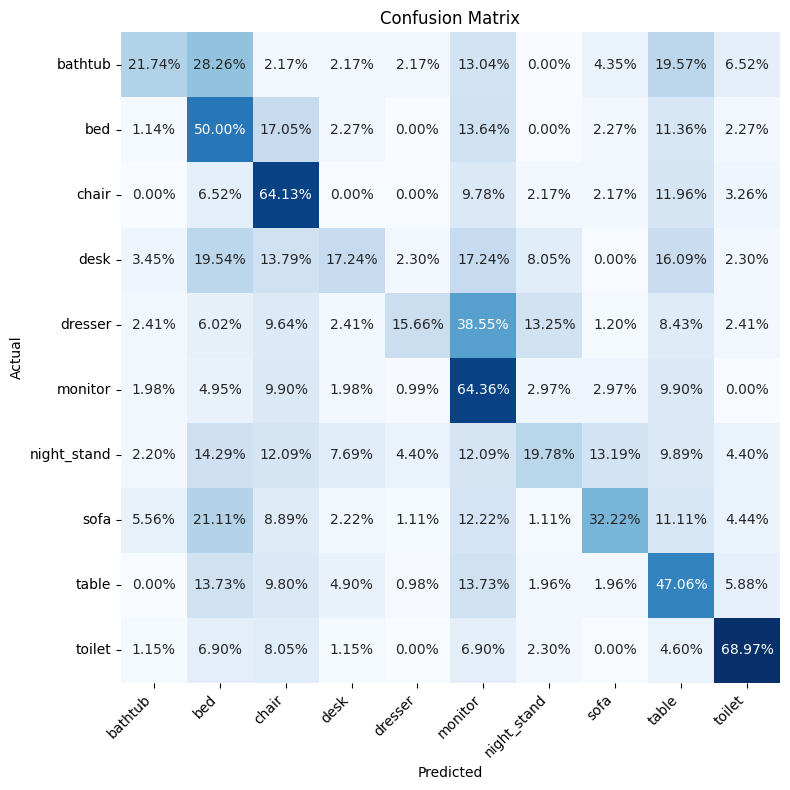

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class_names = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']

# Compute the percentages by dividing each cell by the sum of its row
confusion_percent = confusion / np.sum(confusion, axis=1, keepdims=True)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Create the heatmap with percentages
sns.heatmap(confusion_percent, annot=True, fmt='.2%', cmap='Blues', ax=ax, cbar=False)

# Set the x and y axis labels
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names, rotation=0)

# Add labels to the x and y axes
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Add a title
ax.set_title('Confusion Matrix')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
#Model 1

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import torch
import os
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.multiprocessing as mp
import gzip
from torch.utils.data import random_split
from torchsummary import summary

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_list = os.listdir(folder_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        file_path = os.path.join(self.folder_path, file_name)
        with gzip.open(file_path, 'rb') as f:
            loaded_data = torch.load(f, map_location=torch.device('cpu'))

        data = loaded_data[0]
        label = loaded_data[1]

        # Perform any necessary preprocessing on the data and label
        # ...

        return data, label

In [ ]:
modelnet10path="/content/gdrive/MyDrive/Voxel_Grid_classifier/Data/ModelNet10"
class_names = sorted(os.listdir(modelnet10path))

In [ ]:
class_names

['bathtub',
 'bed',
 'chair',
 'desk',
 'dresser',
 'monitor',
 'night_stand',
 'sofa',
 'table',
 'toilet']

In [ ]:
folder_path= "/content/gdrive/MyDrive/Voxel_Grid_classifier/Data/Transformed_Data/Transform_2/Test_Set"
test_dataset=CustomDataset(folder_path)

In [ ]:
import torch.nn as nn
class CNN3D(nn.Module):
    def __init__(self, num_classes):
        super(CNN3D, self).__init__()

        self.conv1 = nn.Conv3d(1, 48, kernel_size=6, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv3d(48, 160, kernel_size=5, stride=2)
        self.relu = nn.ReLU()
        self.conv3 = nn.Conv3d(160, 512, kernel_size=4, stride=2)
        self.relu = nn.ReLU()
        self.global_pool = nn.AdaptiveMaxPool3d((1, 1, 1))  # Global Max Pooling
        self.fc = nn.Linear(512,128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128,num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.fc2(x)
        return x


# Specify the input shape
input_shape = (1, 60, 60, 60)

In [ ]:
# Load your trained model
model_path = "/content/gdrive/MyDrive/Voxel_Grid_classifier/Model_1/model1_tset.pth"
model = torch.load(model_path, map_location=torch.device('cpu'))

# Set the model to evaluation mode
model.eval()

CNN3D(
  (conv1): Conv3d(1, 48, kernel_size=(6, 6, 6), stride=(2, 2, 2), padding=(1, 1, 1))
  (relu): ReLU()
  (conv2): Conv3d(48, 160, kernel_size=(5, 5, 5), stride=(2, 2, 2))
  (conv3): Conv3d(160, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2))
  (global_pool): AdaptiveMaxPool3d(output_size=(1, 1, 1))
  (fc): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# Define the device to be used for testing (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the specified device
model = model.to(device)

In [ ]:
# Create a DataLoader to efficiently load the test dataset
batch_size = 32  # Adjust this based on your requirements
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Define a criterion if you need to calculate a loss during testing
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix

# Set the random seed for reproducibility
np.random.seed(0)

# Set the model to evaluation mode
model.eval()

total_loss = 0.0
total_correct = 0
total_samples = 0
num_classes=10

print_interval = 10  # Adjust this value as per your preference

# Create an empty confusion matrix
confusion = np.zeros((num_classes, num_classes), dtype=int)

# Disable gradient computation during testing
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(test_loader):
        # Move the data and labels to the device
        data = data.to(device)
        label = label.to(device)

        # Convert the data and model's weight tensor to Double
        data = data.unsqueeze(1)
        data = data.double()
        model.double()

        # Forward pass
        outputs = model(data)

        # Compute the loss
        loss = criterion(outputs, label)

        # Accumulate loss
        total_loss += loss.item()

        # Calculate the predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Update the confusion matrix
        confusion_batch = confusion_matrix(label.cpu().numpy(), predicted.cpu().numpy(), labels=np.arange(num_classes))
        confusion += confusion_batch

        # Count the number of correct predictions
        total_correct += (predicted == label).sum().item()

        # Update the total number of samples
        total_samples += label.size(0)

        # Print intermediate results
        if (batch_idx + 1) % print_interval == 0:
            average_loss = total_loss / (batch_idx + 1)
            accuracy = total_correct / total_samples
            print(f'Batch [{batch_idx+1}/{len(test_loader)}] - Average Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

average_loss = total_loss / len(test_loader)
accuracy = total_correct / total_samples

print(f'Final Results - Average Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
print('Confusion Matrix:')
print(confusion)


Batch [10/28] - Average Loss: 6.7337, Accuracy: 44.38%
Batch [20/28] - Average Loss: 7.6465, Accuracy: 42.81%
Final Results - Average Loss: 7.8111, Accuracy: 43.37%
Confusion Matrix:
[[17 12  4  0  1  2  0  5  3  2]
 [ 1 44 26  3  3  3  0  2  4  2]
 [ 1  8 64  0  0  5  0  2  8  4]
 [ 2 17 16 15  3  8  2  8 11  5]
 [ 2  3 12  3 22 13  5  5 13  5]
 [ 2  5 16  2  3 52  2  7 11  1]
 [ 4  8 21  4  3  7 19 14  6  5]
 [ 5 15 13  2  2  3  0 40  6  4]
 [ 2  8 24  7  3  2  0  9 38  9]
 [ 0  5  8  0  1  1  0  3  4 65]]


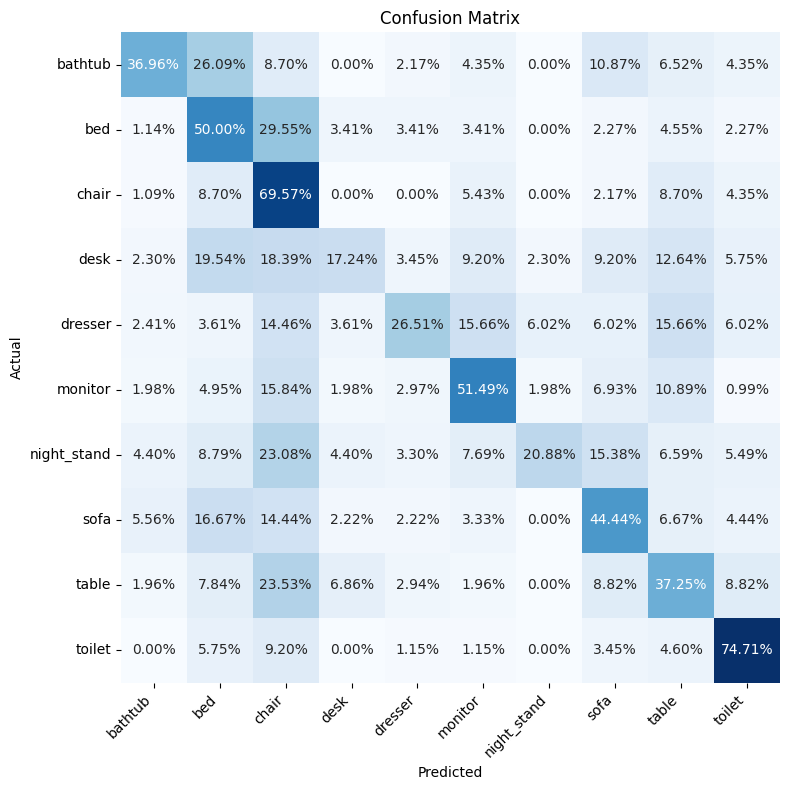

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class_names = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']

# Compute the percentages by dividing each cell by the sum of its row
confusion_percent = confusion / np.sum(confusion, axis=1, keepdims=True)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Create the heatmap with percentages
sns.heatmap(confusion_percent, annot=True, fmt='.2%', cmap='Blues', ax=ax, cbar=False)

# Set the x and y axis labels
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names, rotation=0)

# Add labels to the x and y axes
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Add a title
ax.set_title('Confusion Matrix')

# Display the plot
plt.tight_layout()
plt.show()